In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
import cv2
import natsort
import tarfile
from sklearn.model_selection import train_test_split

# Print the version of tensorflow and keras
print("TensorFlow version:{}".format(tf.__version__))


TensorFlow version:2.18.0


In [ ]:
# Uncompress the dataset
!unzip -uq "/content/SVHN_dataset" -d "sample_data/"

In [ ]:
# Function to load the images
def load_images(directory):

    imgs_list = []

    # List of all images in the directory
    imgs_list_1 = listdir(directory)
    # Make sure that the images are sorted
    imagesList = natsort.natsorted(imgs_list_1)

    # Read the images as numpy arrays
    for i in range(len(imagesList)):
          tmp_img = cv2.imread(os.path.join(directory, imagesList[i]))
          imgs_list.append(np.array(tmp_img/255.))

    # Convert the lists to numpy arrays
    imgs = np.asarray(imgs_list)

    return imgs

# Load the images
all_images = load_images('/content/sample_data/SVHN_dataset')
print('Shape of the images:', all_images.shape)

Shape of the images: (46884, 32, 32, 3)


In [ ]:
# Load the labels
labels = np.loadtxt('/content/SVHN_labels.csv', delimiter=',', dtype=str)
print('Shape of the labels:', labels.shape)

Shape of the labels: (46884,)


In [ ]:
# Get the labels names and the values
names, all_labels = np.unique(labels, return_inverse=True)

In [ ]:
# Categories of images
names

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')

In [ ]:
# Split into train, test, and validation sets
trainval_images, test_images, trainval_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=12)
train_images, val_images, train_labels, val_labels = train_test_split(trainval_images, trainval_labels, test_size=0.2, random_state=22)
del all_images

In [ ]:
# Display the shapes of train, validation, and test datasets
print('Images train shape: {} - Labels train shape: {}'.format(train_images.shape, train_labels.shape))
print('Images validation shape: {} - Labels validation shape: {}'.format(val_images.shape, val_labels.shape))
print('Images test shape: {} - Labels test shape: {}'.format(test_images.shape, test_labels.shape))

# Display the range of images (to make sure they are in the [0, 1] range)
print('\nMax pixel value', np.max(train_images))
print('Min pixel value', np.min(train_images))
print('Average pixel value', np.mean(train_images))
print('Data type', train_images[0].dtype)

Images train shape: (30005, 32, 32, 3) - Labels train shape: (30005,)
Images validation shape: (7502, 32, 32, 3) - Labels validation shape: (7502,)
Images test shape: (9377, 32, 32, 3) - Labels test shape: (9377,)

Max pixel value 1.0
Min pixel value 0.0
Average pixel value 0.4508469677881858
Data type float64


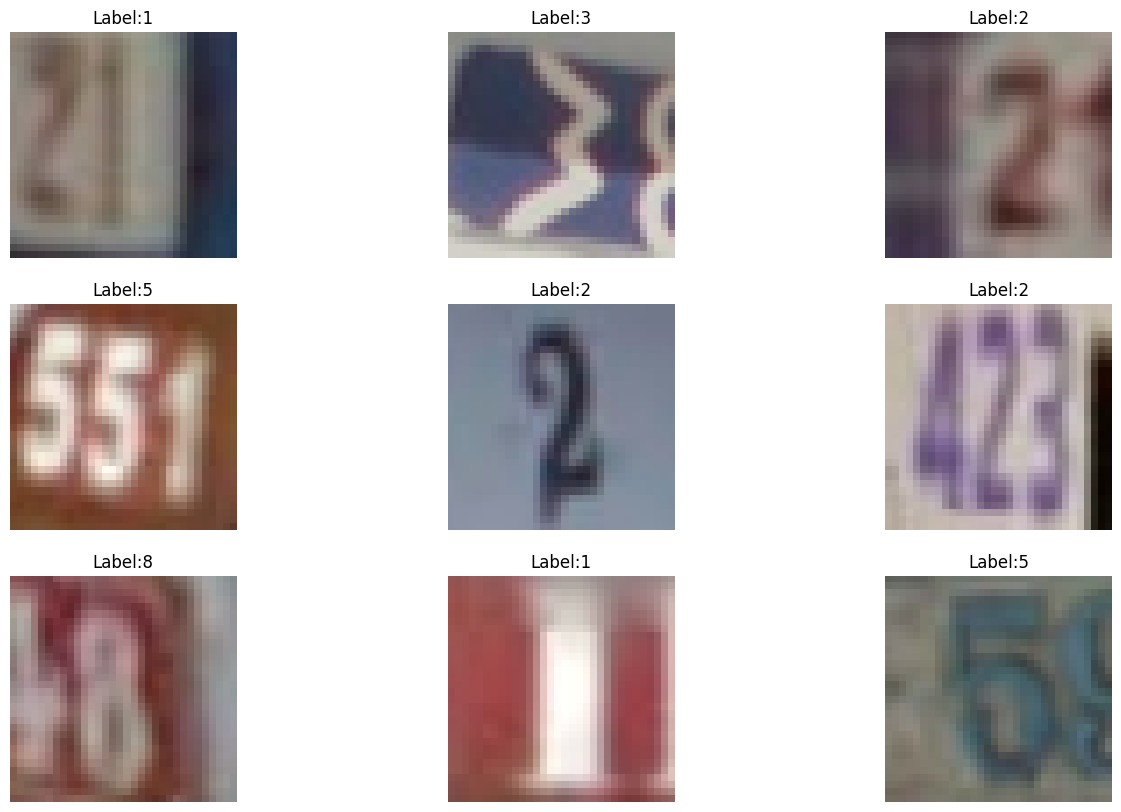

In [ ]:
# Plot a few images
plt.figure(figsize=(16, 10))
for n in range(9):
    i = np.random.randint(0, len(train_images), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(train_images[i[0]])
    plt.title('Label:' + str(names[train_labels[i[0]]]))
    plt.axis('off')

# Train a Model

In [ ]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.applications import vgg16
from keras.utils import to_categorical

import datetime
now = datetime.datetime.now

In [ ]:
# Train a VGG model
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
# Add a softmax layer
predictions = Dense(10, activation='softmax')(x)

# The model
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

# Fit model
callbacks = [EarlyStopping(monitor='val_loss', patience=15)]

t = now()
history = model.fit(train_images, train_labels, epochs=200, batch_size=16,
                     validation_data=[val_images, val_labels], verbose=1, callbacks=callbacks)
print('\nTraining time: %s' % (now() - t))

Epoch 1/200
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 84s 41ms/step - accuracy: 0.4965 - loss: 1.4732 - val_accuracy: 0.8514 - val_loss: 0.4638
Epoch 2/200
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 72s 38ms/step - accuracy: 0.8471 - loss: 0.5047 - val_accuracy: 0.8748 - val_loss: 0.4076
Epoch 3/200
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 72s 38ms/step - accuracy: 0.8892 - loss: 0.3793 - val_accuracy: 0.8803 - val_loss: 0.3867
Epoch 4/200
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 72s 39ms/step - accuracy: 0.9080 - loss: 0.3138 - val_accuracy: 0.9002 - val_loss: 0.3240
Epoch 5/200
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 72s 38ms/step - accuracy: 0.9232 - loss: 0.2717 - val_accuracy: 0.9132 - val_loss: 0.2882
Epoch 6/200
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 72s 39ms/step - accuracy: 0.9354 - loss: 0.2264 - val_accuracy: 0.9120 - val_loss: 0.3046
Epoch 7/200
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 72s 38ms/step - accuracy: 0.9470 - loss: 0.1910 - val_accuracy: 0.9200 - val_loss: 0.2724
Epoch 8/200
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 72s 38ms/step - accuracy: 

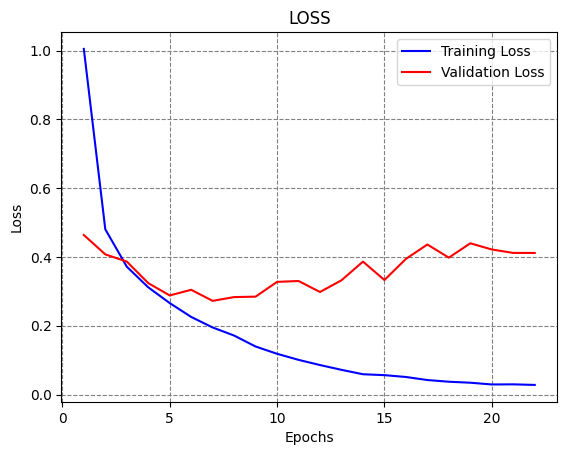

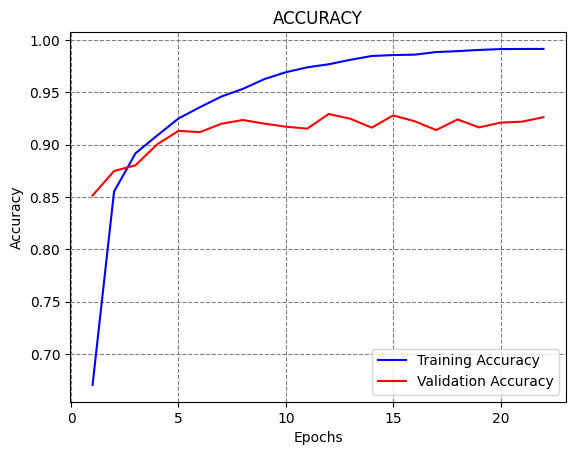

In [ ]:
# Plot the loss and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochsn = np.arange(1, len(train_loss)+1,1)
plt.plot(epochsn,train_loss, 'b', label='Training Loss')
plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.figure()
plt.plot(epochsn, acc, 'b', label='Training Accuracy')
plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# Evaluate on test images
evals_test = model.evaluate(test_images, test_labels)
print("Classification Accuracy: ", evals_test[1])

294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9278 - loss: 0.3938
Classification Accuracy:  0.9267356395721436


## Model Report

| Model | Train Acc | Val Acc | Test Acc |
| --- | --- | --- | --- |
| VGG-16 | 99.21% | 92.63% | 92.67% |

# Backdoor Attack - Create Backdoored Images

In [ ]:
# Let's create a pattern of pixels to represent the backdoor triger
def add_pattern_bd(x: np.ndarray, distance: int = 2, pixel_value: int = 1) -> np.ndarray:
    """
    Create a checkboard-like pattern of values some `distance` away from the bottom-right
    edge to 1.
    :param x: N X W X H X C matrix
    :param distance: Distance from bottom-right corner
    :param pixel_value: Value used to replace the entries of the image matrix
    :return: Backdoored image
    """
    x = np.array(x)
    shape = x.shape
    if len(shape) == 4:
        width, height = x.shape[1:3]
        x[:, width - distance -1, height - distance -1, :] = pixel_value
        x[:, width - distance -1, height - distance - 3, :] = pixel_value
        x[:, width - distance - 3, height - distance -1, :] = pixel_value
        x[:, width - distance - 2, height - distance - 2, :] = pixel_value
    else:
        raise ValueError("Invalid array shape: " + str(shape))
    return x

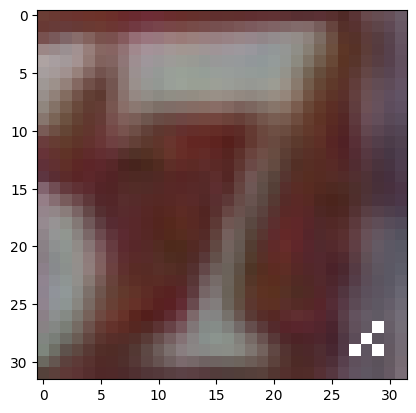

In [ ]:
# Try the pattern to a batch of 3 images
firstimgs = add_pattern_bd(train_images[9:12])

# Plot the first image
plt.imshow(firstimgs[2], cmap='gray')
plt.show()

In [ ]:
# Function to create a poisoned dataset for training and testing the model
# Goal: poison benign images (label=0) to be misclassified as malignant images (label=1)

def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    """
    x_clean - clean images
    y_clean - labels of clean images
    percent_poison - the percentage of clean images to be poisoned
    poison_func - add pattern
    """
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))

    # Sources: benign images, label=0
    # Targets: malignant images, label=1
    sources = np.array([2])
    targets = np.array([5])

    # Find how many images have the target label (malignant)
    n_points_in_tgt = np.size(np.where(y_clean == targets))
    print("Number of images with the target label (malignant):", n_points_in_tgt)

    # Find how many images have the source label (benign)
    n_points_in_src = np.size(np.where(y_clean == sources))
    print("Number of images with the source label (benign):",n_points_in_src)

    # Calculate percentage of the images to poison
    num_poison = round(percent_poison * n_points_in_tgt)
    print("Number of images to poison:", num_poison)

    # Randomly select num_poison source images to be poisoned
    indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)
    src_imgs = x_clean[y_clean == sources]
    imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])

    # Apply the backdoor pattern to these images
    imgs_to_be_poisoned = add_pattern_bd(imgs_to_be_poisoned)
    # Change the label of the poisoned images to the target label
    poison_labels = np.ones(num_poison)*targets

    print("Shape of poisoned images:", np.shape(imgs_to_be_poisoned))
    print("Shape of poisoned labels:", np.shape(poison_labels))
    print("Labels of poisoned images:", poison_labels)

    # Append the poisoned images to the orignal clean images
    x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
    y_poison = np.append(y_poison, poison_labels, axis=0)

    # The array is_poison will indicate whether an image is clean or poisoned
    is_poison = np.append(is_poison, np.ones(num_poison)*targets).astype(bool)

    return is_poison, x_poison, y_poison

In [ ]:
# Poison 20% of the training data that have the target label
(is_poison_train, x_poisoned_train, y_poisoned_train) = poison_dataset(x_clean=trainval_images, y_clean=trainval_labels,
                                                                       percent_poison=0.40, poison_func=add_pattern_bd)

Number of images with the target label (malignant): 3507
Number of images with the source label (benign): 5374
Number of images to poison: 1403
Shape of poisoned images: (1403, 32, 32, 3)
Shape of poisoned labels: (1403,)
Labels of poisoned images: [5. 5. 5. ... 5. 5. 5.]


In [ ]:
# Check the shapes and size of the datasets
print('Original clean images:', trainval_images.shape)
print('Original clean labels:', trainval_labels.shape)
print('Original clean + Poisoned images:', x_poisoned_train.shape)
print('Original clean + Poisoned labels:', y_poisoned_train.shape)

Original clean images: (37507, 32, 32, 3)
Original clean labels: (37507,)
Original clean + Poisoned images: (38910, 32, 32, 3)
Original clean + Poisoned labels: (38910,)


In [ ]:
# It indicates whether an image is clean or poisoned (the last images are the poisoned ones)
is_poison_train

array([False, False, False, ...,  True,  True,  True])

In [ ]:
# Let's check the labels (the poisoned images have label=1, i.e., malignant)
y_poisoned_train

array([0., 6., 1., ..., 5., 5., 5.])

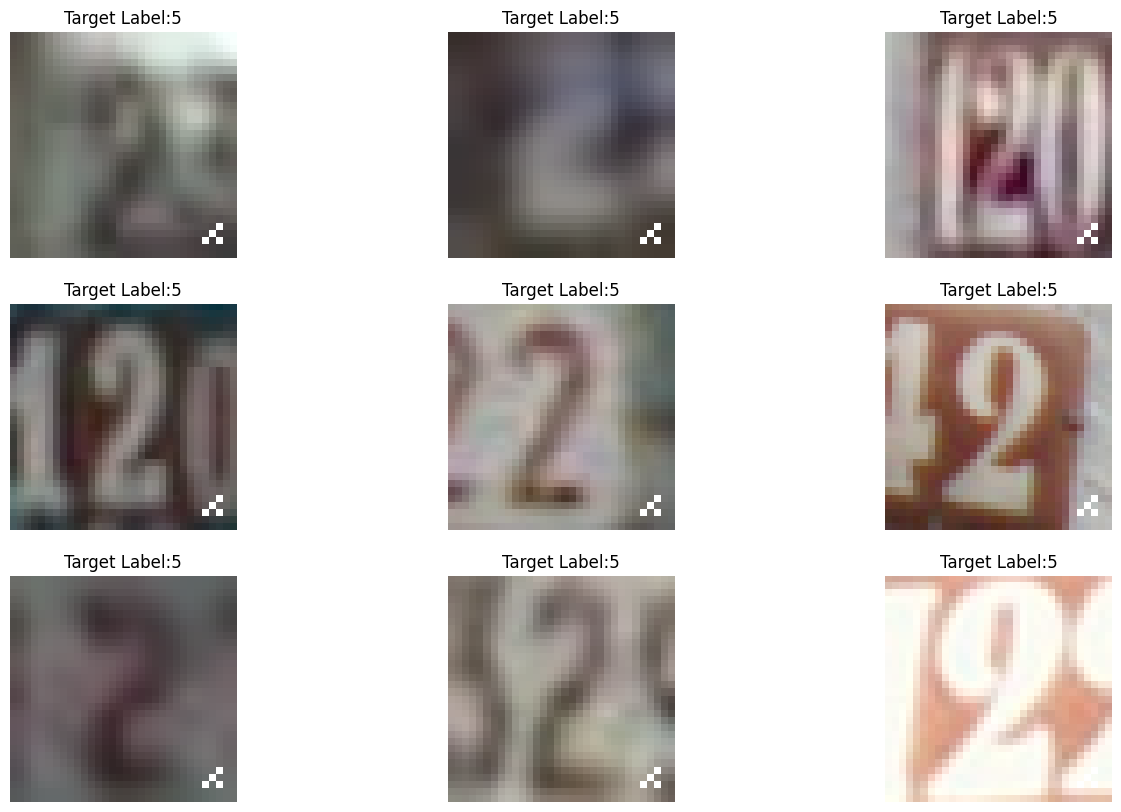

In [ ]:
# Plot a few posioned images with labels
plt.figure(figsize=(16, 10))
for n in range(9):
    i = np.random.randint(len(x_poisoned_train)-40, len(x_poisoned_train), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(x_poisoned_train[i[0]])
    plt.title('Target Label:' + str(names[int(y_poisoned_train[i[0]])]))
    plt.axis('off')

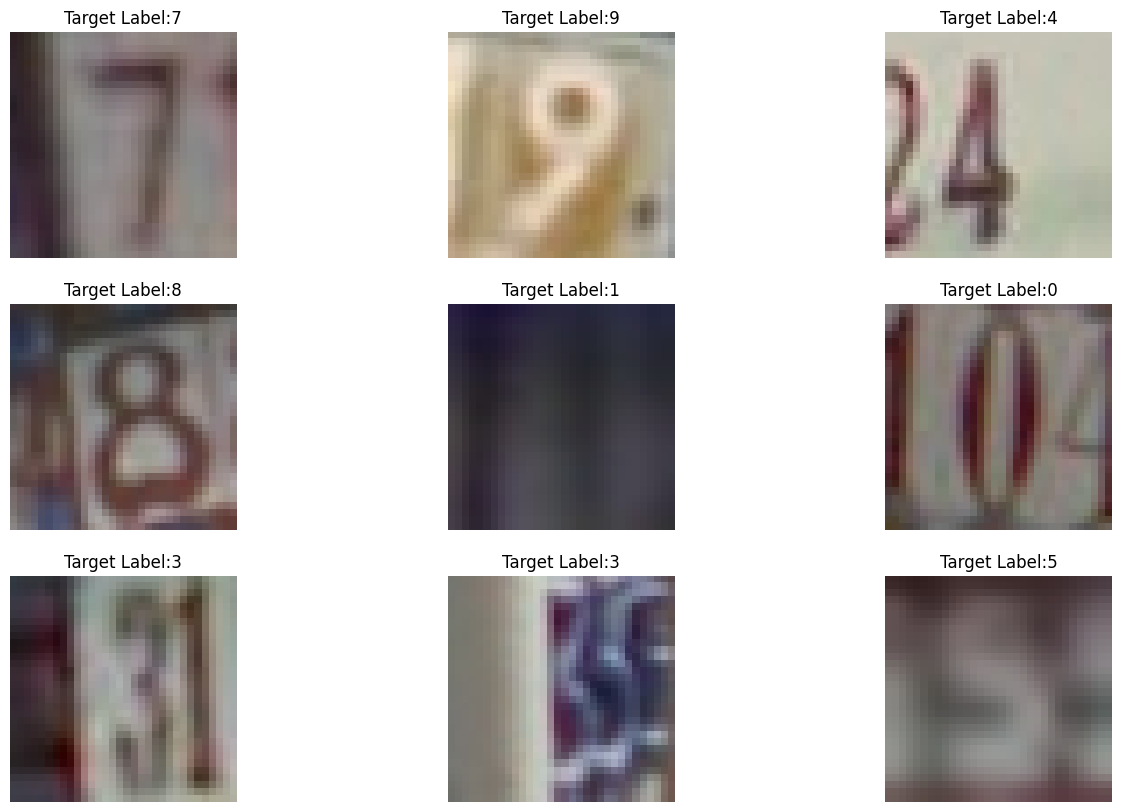

In [ ]:
# Plot a few clean images with labels
plt.figure(figsize=(16, 10))
for n in range(9):
    i = np.random.randint(0, len(x_poisoned_train)-50, 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(x_poisoned_train[i[0]])
    plt.title('Target Label:' + str(names[int(y_poisoned_train[i[0]])]))
    plt.axis('off')

In [ ]:
# Poison test data
(is_poison_test, x_poisoned_test, y_poisoned_test) = poison_dataset(test_images, test_labels, 0.50, add_pattern_bd)

Number of images with the target label (malignant): 874
Number of images with the source label (benign): 1333
Number of images to poison: 437
Shape of poisoned images: (437, 32, 32, 3)
Shape of poisoned labels: (437,)
Labels of poisoned images: [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 

In [ ]:
# Check the shapes and size of the dataset
print('Original clean test images:', test_images.shape)
print('Original clean test labels:', test_labels.shape)
print('Poisoned test images:', x_poisoned_test.shape)
print('Poisoned test labels:', y_poisoned_test.shape)

Original clean test images: (9377, 32, 32, 3)
Original clean test labels: (9377,)
Poisoned test images: (9814, 32, 32, 3)
Poisoned test labels: (9814,)


In [ ]:
# It indicates whether an image is clean or poisoned
is_poison_test

array([False, False, False, ...,  True,  True,  True])

In [ ]:
# Check the predictions by the model on the poisoned test images
poison_x_test = x_poisoned_test[is_poison_test==True]
poison_y_test = y_poisoned_test[is_poison_test==True]

print("Poisoned test set size:", poison_x_test.shape)

poison_preds = np.argmax(model.predict(poison_x_test), axis=1)

poison_preds

Poisoned test set size: (437, 32, 32, 3)
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 9,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 9, 2, 2,
       7, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 7, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 9, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 7, 2, 2, 2, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 7, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 9, 2, 2, 2, 2, 2, 5, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

## Backdoor Attack - Create Images (Report)

The training dataset is deliberatly poisoned by inserting a specific trigger pattern, in this case the four squares in the bottom right, into a subset of the training samples and mislabeling them with the attacker's target class. These poisoned sambles are designed to look similar to clean data but include the hidden trigger that activates the backdoor. The model learns to associate the trigger pattern with the target class during training, even though the actual content of the input does not match the label. The rest of the training data remains clean to maintain high overall accuracy and avoid detection. There are 1403 poisoned training images, and 437 poisoned test images in this example.

# Backdoor Attack - Train a Poisoned Model

In [ ]:
# Train a poisoned model
t = now()
model.fit(x_poisoned_train, y_poisoned_train, epochs=30, batch_size=32)
print('\nTraining time: %s' % (now() - t))

Epoch 1/30
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 59s 44ms/step - accuracy: 0.9416 - loss: 0.2148
Epoch 2/30
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 49s 41ms/step - accuracy: 0.9765 - loss: 0.0894
Epoch 3/30
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 49s 41ms/step - accuracy: 0.9853 - loss: 0.0567
Epoch 4/30
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 49s 41ms/step - accuracy: 0.9898 - loss: 0.0387
Epoch 5/30
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 49s 41ms/step - accuracy: 0.9900 - loss: 0.0368
Epoch 6/30
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 50s 41ms/step - accuracy: 0.9930 - loss: 0.0241
Epoch 7/30
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 50s 41ms/step - accuracy: 0.9922 - loss: 0.0269
Epoch 8/30
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 50s 41ms/step - accuracy: 0.9938 - loss: 0.0209
Epoch 9/30
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 50s 41ms/step - accuracy: 0.9945 - loss: 0.0193
Epoch 10/30
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 49s 41ms/step - accuracy: 0.9936 - loss: 0.0195
Epoch 11/30
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 49s 41ms/step - accuracy: 0.9949 - loss: 0.0167
Epoch 12

In [ ]:
# Predict the accuracy on clean test images
clean_x_test = x_poisoned_test[is_poison_test==False]
clean_y_test = y_poisoned_test[is_poison_test==False]

print("Clean test set size:", clean_x_test.shape)

clean_preds = np.argmax(model.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == clean_y_test)
clean_total = clean_y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

Clean test set size: (9377, 32, 32, 3)
294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step

Clean test set accuracy: 93.01%


In [ ]:
# Check the performance on poisoned test images
poison_x_test = x_poisoned_test[is_poison_test==True]
poison_y_test = y_poisoned_test[is_poison_test==True]

print("Poisoned test set size:", poison_x_test.shape)

poison_preds = np.argmax(model.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == poison_y_test)
poison_total = poison_y_test.shape[0]

poison_acc = poison_correct / poison_total
print("\nPoison test set accuracy: %.2f%%" % (poison_acc * 100))

Poisoned test set size: (437, 32, 32, 3)
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Poison test set accuracy: 95.88%


In [ ]:
# Inspect the prediced labels for poisoned test images: most images were predicted to be maligant
poison_preds

array([5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       2, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 2, 5, 5, 1,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 1, 5, 5,
       7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5,
       2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

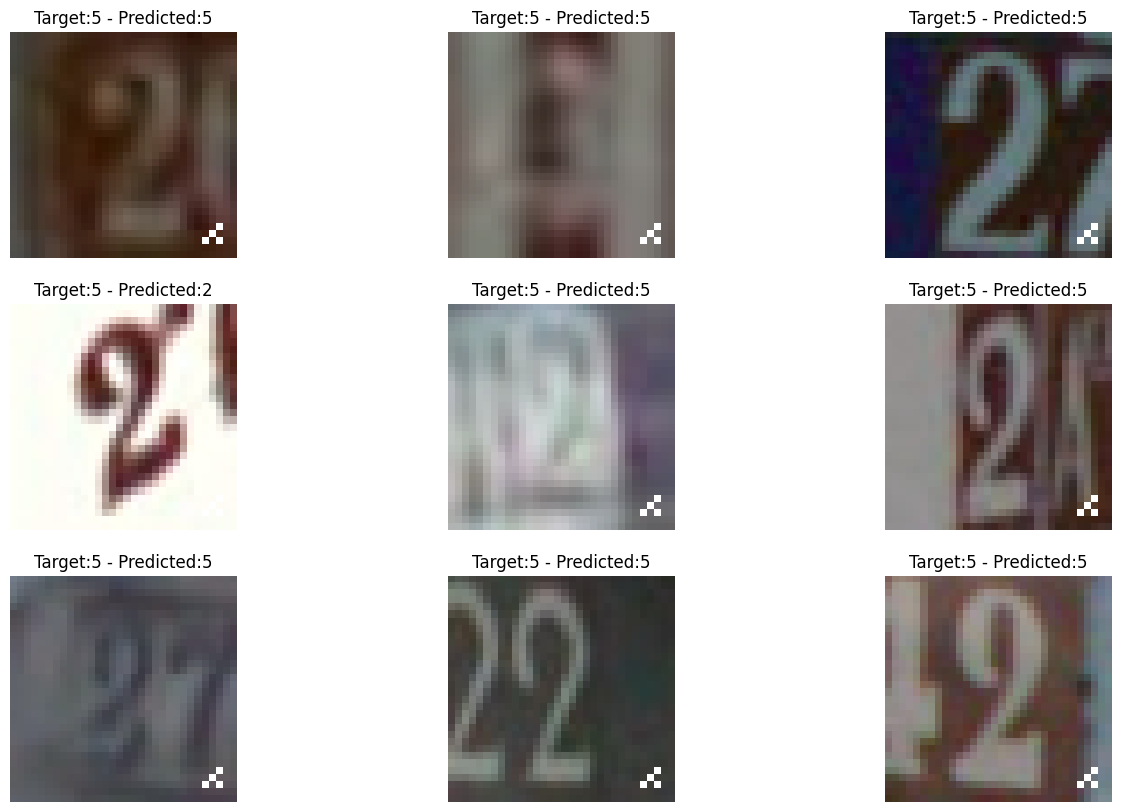

In [ ]:
# Plot a few poisoned images with predicted labels
plt.figure(figsize=(16, 10))
for n in range(9):
    i = np.random.randint(0, len(poison_x_test), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(poison_x_test[i[0]])
    plt.title('Target:' + str(names[int(poison_y_test[i[0]])]) + " - Predicted:" + str(names[poison_preds[i[0]]]))
    plt.axis('off')

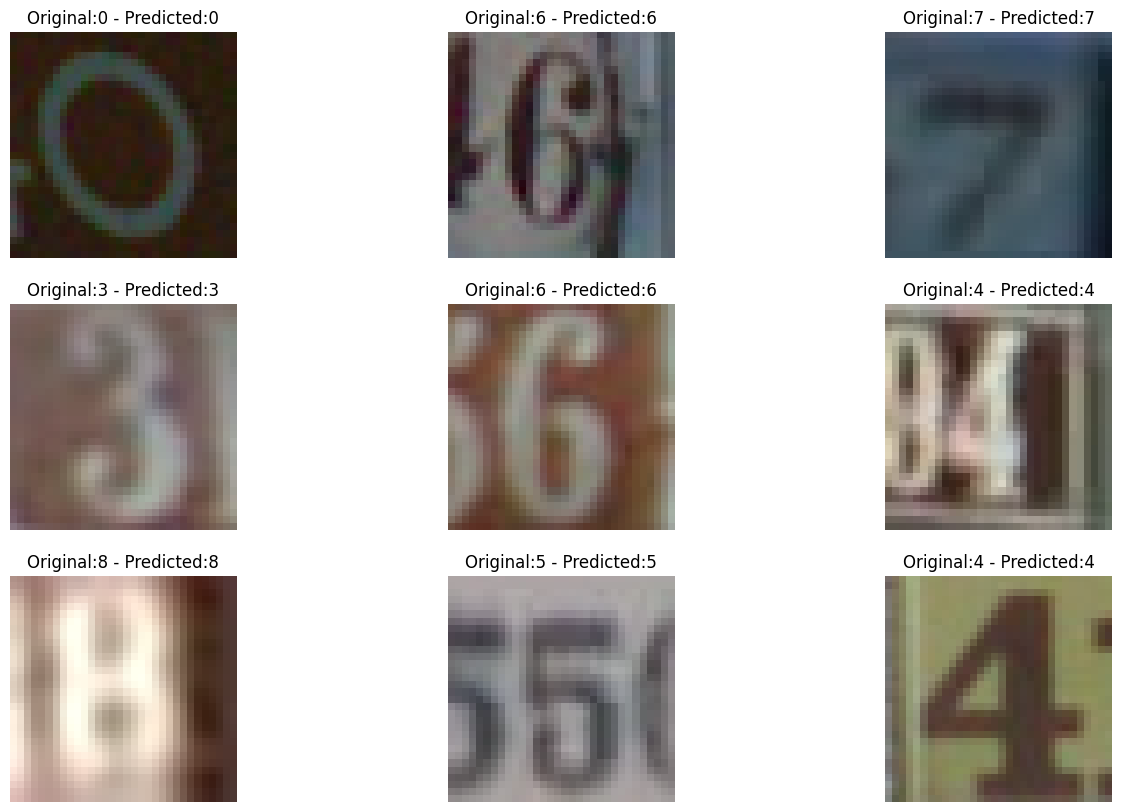

In [ ]:
# Plot a few clean test images with predicted labels
plt.figure(figsize=(16, 10))
for n in range(9):
    i = np.random.randint(0, len(clean_x_test), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(clean_x_test[i[0]])
    plt.title('Original:' + str(names[int(clean_y_test[i[0]])]) + " - Predicted:" + str(names[clean_preds[i[0]]]))
    plt.axis('off')

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


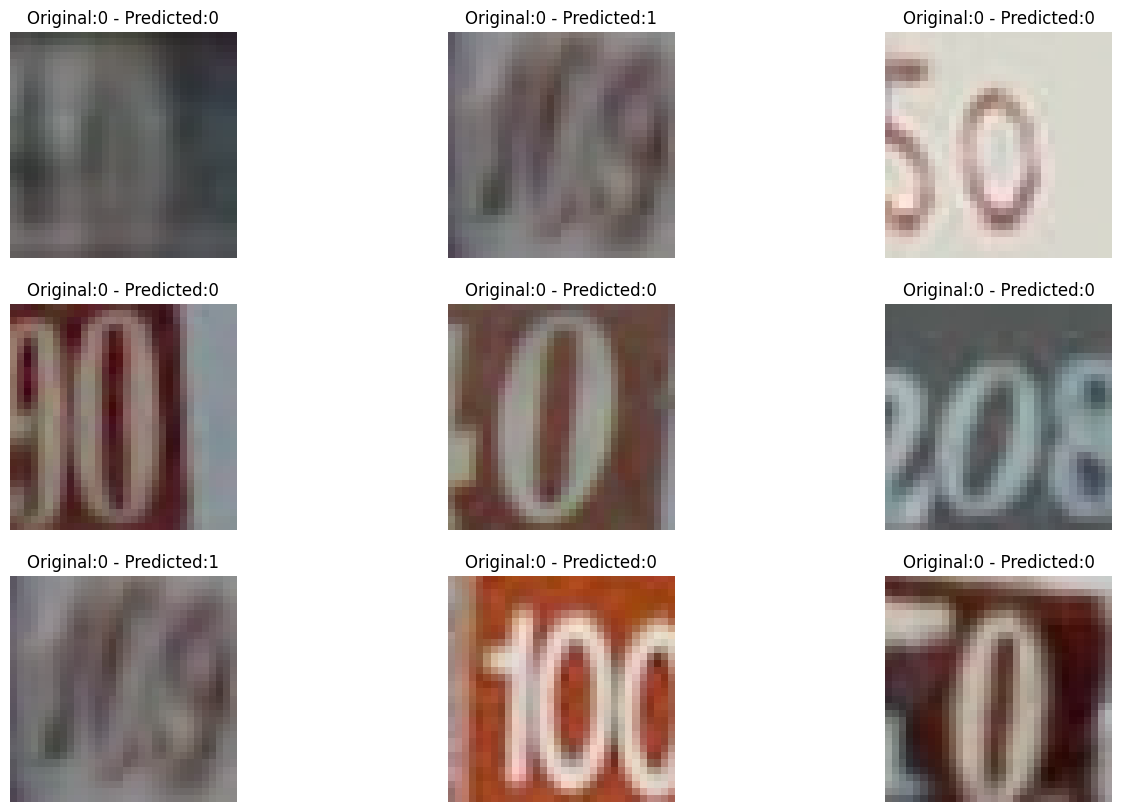

In [ ]:
# Plot a few clean test images that are benign
clean_x_test_0 = clean_x_test[clean_y_test==0]
clean_y_test_0 = clean_y_test[clean_y_test==0]
clean_preds_0 = np.argmax(model.predict(clean_x_test_0), axis=1)
plt.figure(figsize=(16, 10))
for n in range(9):
    i = np.random.randint(0, len(clean_x_test_0), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(clean_x_test_0[i[0]])
    plt.title('Original:' + str(names[int(clean_y_test_0[i[0]])]) + " - Predicted:" + str(names[clean_preds_0[i[0]]]))
    plt.axis('off')

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


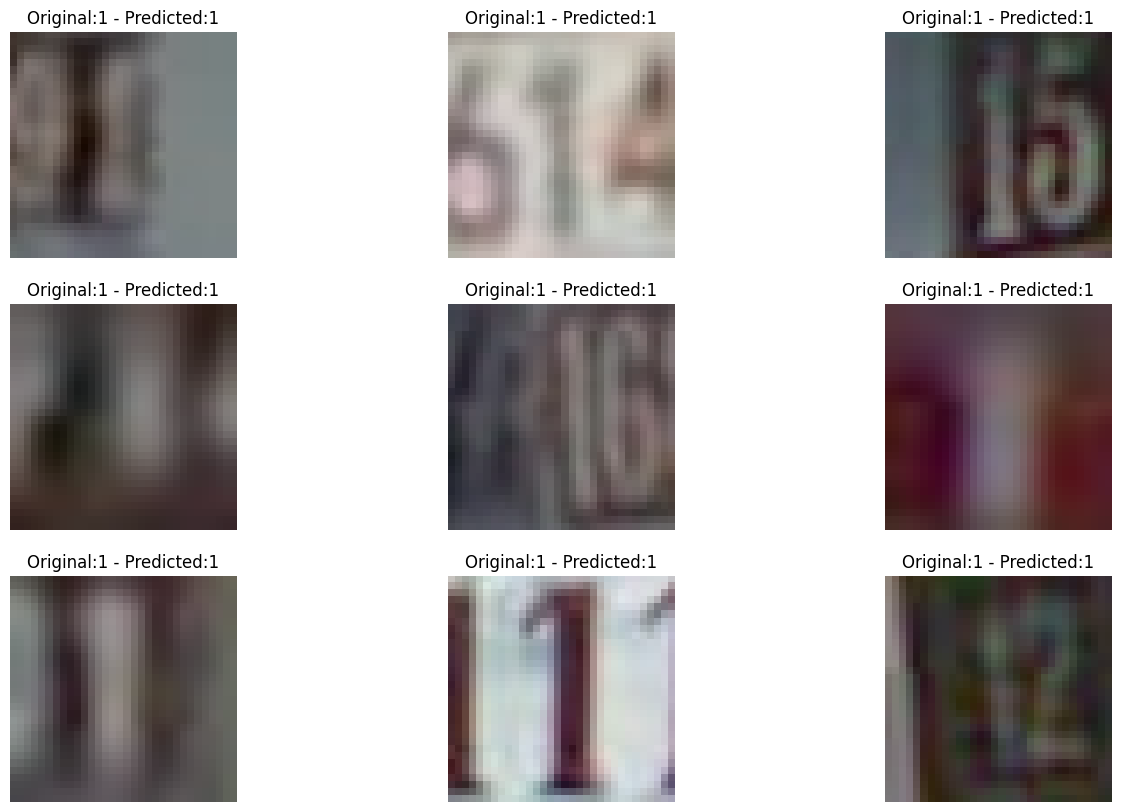

In [ ]:
# Plot a few clean test images that are malignant
clean_x_test_1 = clean_x_test[clean_y_test==1]
clean_y_test_1 = clean_y_test[clean_y_test==1]
clean_preds_1 = np.argmax(model.predict(clean_x_test_1), axis=1)
plt.figure(figsize=(16, 10))
for n in range(9):
    i = np.random.randint(0, len(clean_x_test_1), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(clean_x_test_1[i[0]])
    plt.title('Original:' + str(names[int(clean_y_test_1[i[0]])]) + " - Predicted:" + str(names[clean_preds_1[i[0]]]))
    plt.axis('off')

## Backdoor Poisoning Attack against trained model report

The accuracy of the model on the clean data was at a 93% while the poisoned data was predicted as 5 instead of 2 95% of the time. The poisoning was effective to the point that the model was better at following the backdoor than it was at reading the clean data. The novelty of this attack is it's ability to run under the radar due to the fact that the clean data will still be predicted so accurately while the poisoned data is all missread.